<a href="https://colab.research.google.com/github/cardstud/DS-Unit-2-Kaggle-Challenge/blob/master/module4/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

### Code given to us

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

### My model thus far

In [33]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier()
)
param = {
    'simpleimputer__strategy': ['median', 'mean'],
    'randomforestclassifier__n_estimators': [100,200],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__max_depth': [10,20],
    'randomforestclassifier__min_samples_leaf': [5,7],
    'randomforestclassifier__min_samples_split': [2,3]
}
# If you're on Colab, decrease n_iter & cv parameters # estar n_iter=100 e n_iter=10
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param, 
    random_state=42,
    n_iter=2, 
    cv=2, 
    scoring= 'accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train)
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)
y_pred = search.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   12.5s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   27.5s finished


Best hyperparameters {'simpleimputer__strategy': 'mean', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 7, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__bootstrap': True}
Cross-validation Accuracy -0.7837573819990231
Validation Accuracy 0.7993453127176487


### Confusion Matrix

In [0]:
# One way to do this

In [34]:
# Step 1 - compute the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)  # y_val is true values, y_pred is prediction values

array([[7252,   59,  487],
       [ 703,  204,  136],
       [1460,   36, 4021]])

In [35]:
# Step 2 - get the unique labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

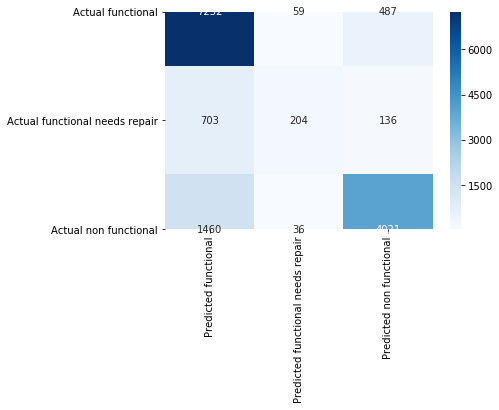

In [36]:
# make a function
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)   # in this case, y_true is y_val
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]

  # make the dataframe
  df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                                     columns = columns,
                                     index=index)
  # return a heatmap
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_val, y_pred)

In [37]:
# Another way to do this without using the function above - use scikiplot as skplt
!pip install scikit-plot

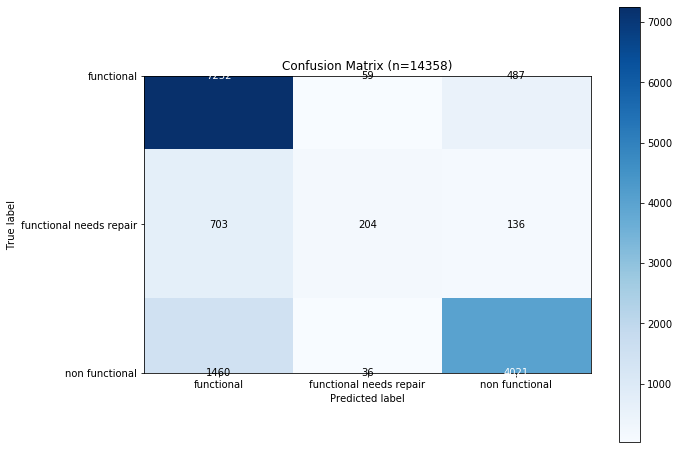

In [40]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_val, y_pred,
                                    figsize=(10,8),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

### How many correct predictions were made?

In [41]:
7252 + 204 + 4351

11807

### How many total predictions were made?

In [42]:
len(y_val)  # or add all numbers

14358

### What was the classification accuracy?

In [43]:
# Total correct predictions/Total predictions
11807/14358

0.8223290151831731

### Use classification metrics: precision, recall

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
# support= how many samples for each in the dataset

                         precision    recall  f1-score   support

             functional       0.77      0.93      0.84      7798
functional needs repair       0.68      0.20      0.30      1043
         non functional       0.87      0.73      0.79      5517

               accuracy                           0.80     14358
              macro avg       0.77      0.62      0.65     14358
           weighted avg       0.80      0.80      0.78     14358



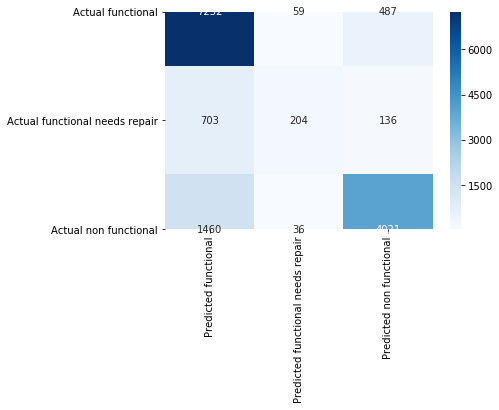

In [45]:
plot_confusion_matrix(y_val, y_pred)

### How many correct predictions of "non functional"?

In [0]:
# 1st
correct_non_functional = 4021

### How many total predictions of "non functional"?

In [0]:
# 2nd - count up last column
total_pred_non_functional = 4021 + 136 + 487

### What's the precision for "non functional"?

In [48]:
# 3rd -divide top 2 (how many corrected over how many times predicted is precision)
precision_non_functional = correct_non_functional/total_pred_non_functional
precision_non_functional

0.865848406546081

### How many actual "non functional" waterpumps?

In [0]:
# sum up bottom row
total_actual_non_functional = 1460 + 36 + 4021

### What's the recall for "non functional"?

In [50]:
correct_non_functional/total_actual_non_functional

0.7288381366684793

### Understand the relationships between precision, recall, thresholds, and predicted probabilities, to help make decisions and allocate budgets

In [51]:
len(test)

14358

**You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.** You want to predict, which 2,000 are most likely non-functional or in need of repair, to help you triage and prioritize your waterpump inspections.

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

In [52]:
len(train) + len(val)

59400

In [53]:
len(val)

14358

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

Based on this historical data, if you randomly chose waterpumps to inspect, then about 46% of the waterpumps would need repairs, and 54% would not need repairs.

In [54]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [55]:
# random guess not best way to predict
2000 * 0.46

920.0

In this scenario, we should define our target differently. We want to identify which waterpumps are non-functional _or_ are functional but needs repair:

In [56]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

We already made our validation set the same size as our test set.

In [58]:
len(val) == len(test)

True

We can refit our model, using the redefined target.

Then make predictions for the validation set.

In [57]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [60]:
confusion_matrix(y_val, y_pred)  # y_val is true values, y_pred is prediction values

array([[6830,  968],
       [1868, 4692]])

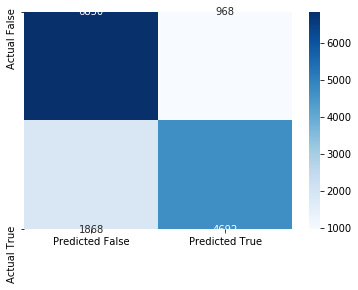

In [59]:
plot_confusion_matrix(y_val, y_pred)

How many total predictions of "True" ("non functional" or "functional needs repair") ?

In [61]:
4692 + 968

5660

We don't have "budget" to take action on all these predictions
But we can get predicted probabilities, to rank the predictions.
Then change the threshold, to change the number of positive predictions, based on our budget.

### Get predicted probabilities and plot the distribution

In [62]:
# Discrete binary predictions...
y_pred

array([ True,  True, False, ..., False,  True, False])

In [63]:
# might be more useful to use this
# Predicted probabilities for positive class
pipeline.predict_proba(X_val)

# 0. , 1.   -- all 100 decision trees predicted all need repair
# 0.25, 0.74 -- 74% decision predicted repair

array([[0. , 1. ],
       [0.2, 0.8],
       [0.9, 0.1],
       ...,
       [0.8, 0.2],
       [0.3, 0.7],
       [1. , 0. ]])

In [64]:
pipeline.predict_proba(X_val)[:,1]

array([1. , 0.8, 0.1, ..., 0.2, 0.7, 0. ])

In [0]:
# What happens to the probabilities with fewer or more estimators
# go back to fit line and change number of estimators to more or fewer

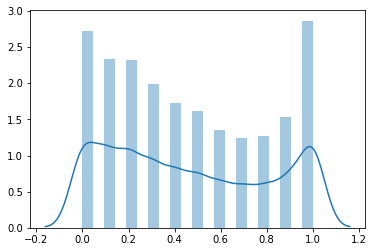

In [65]:
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
sns.distplot(y_pred_proba);

### Change the threshold

False    12399
True      1959
dtype: int64

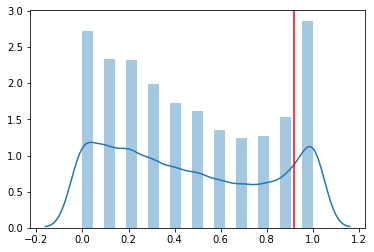

In [66]:
# We can change the threshold
threshold = 0.92

y_pred_proba = pipeline.predict_proba(X_val)[:,1]
y_pred = y_pred_proba > threshold

ax=sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

# Everything to right is true, everything to left is false

### Or, get exactly 2,000 positive predictions

Identify the 2,000 waterpumps in the validation set with highest predicted probabilities.

In [67]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})
top2000=results.sort_values(by='y_pred_proba', ascending=False)[:2000]
top2000

,y_val,y_pred_proba
58046,True,1.0
34124,True,1.0
59252,True,1.0
18031,True,1.0
58018,True,1.0
...,...,...
34753,True,0.9
38323,True,0.9
33268,True,0.9
48741,True,0.9


Most of these top 2,000 waterpumps will be relevant recommendations, meaning y_val==True, meaning the waterpump is non-functional or needs repairs.

Some of these top 2,000 waterpumps will be irrelevant recommendations, meaning y_val==False, meaning the waterpump is functional and does not need repairs.

Let's look at a random sample of 50 out of these top 2,000:



In [68]:
top2000.sample(n=50)

,y_val,y_pred_proba
38284,True,1.0
3708,True,1.0
25441,True,1.0
10405,True,1.0
47348,True,1.0
690,True,1.0
47713,True,1.0
11696,True,1.0
7625,True,1.0
54673,True,1.0


So how many of our recommendations were relevant? ...

In [69]:
trips=2000
print(f'Baseline: {trips*0.46} waterpump repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 920.0 waterpump repairs in 2000 trips
With model: Predict 1950 waterpump repairs in 2000 trips


What's the precision for this subset of 2,000 predictions?

In [70]:
precision_at_k_2000 = relevant_recommendations/trips
print('Precision @ k=2000', precision_at_k_2000)

Precision @ k=2000 0.975


In this scenario ...
Accuracy isn't the best metric!

Instead, change the threshold, to change the number of positive predictions, based on the budget. (You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.)

Then, evaluate with the precision for "non functional"/"functional needs repair".

This is conceptually like Precision@K, where k=2,000.

Read more here: Recall and Precision at k for Recommender Systems: Detailed Explanation with examples

Precision at k is the proportion of recommended items in the top-k set that are relevant

Mathematically precision@k is defined as: Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)

In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

We asked, can you do better than random at prioritizing inspections?

If we had randomly chosen waterpumps to inspect, we estimate that only 920 waterpumps would be repaired after 2,000 maintenance visits. (46%)

But using our predictive model, in the validation set, we succesfully identified over 1,900 waterpumps in need of repair!

So we will use this predictive model with the dataset of over 14,000 waterpumps that we do have some information about, but we don't know whether they are currently functional, or functional but need repair, or non-functional.

We will predict which 2,000 are most likely non-functional or in need of repair.

We estimate that approximately 1,900 waterpumps will be repaired after these 2,000 maintenance visits.

So we're confident that our predictive model will help triage and prioritize waterpump inspections.

But ...
This metric (~1,900 waterpumps repaired after 2,000 maintenance visits) is specific for one classification problem and one possible trade-off.

Can we get an evaluation metric that is generic for all classification problems and all possible trade-offs?

Yes — the most common such metric is ROC AUC.

### Get ROC AUC (Receiver Operating Characteristic, Area Under the Curve)

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. **The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.**"

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures **how well a classifier ranks predicted probabilities.** So, when you get your classifier’s ROC AUC score, you need to **use predicted probabilities, not discrete predictions.**

ROC AUC ranges **from 0 to 1.** Higher is better. A naive majority class **baseline** will have an ROC AUC score of **0.5.** 

#### Scikit-Learn docs
- [User Guide: Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc)
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

#### More links
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

In [0]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [73]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.00
1,0.006027,0.291463,1.00
2,0.017312,0.438110,0.90
3,0.035907,0.548323,0.80
4,0.035907,0.548476,0.75
5,0.067966,0.640549,0.70
6,0.124134,0.715244,0.60
7,0.198128,0.795274,0.50
8,0.295204,0.860366,0.40
9,0.423955,0.915244,0.30


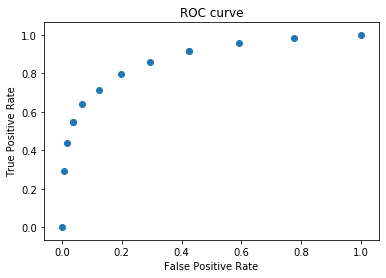

In [74]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [75]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.8796233223496956

Recap: ROC AUC measures how well a classifier ranks predicted probabilities. So, when you get your classifier’s ROC AUC score, you need to use predicted probabilities, not discrete predictions.

Your code may look something like this:

from sklearn.metrics import roc_auc_score
y_pred_proba = model.predict_proba(X_test_transformed)[:, -1] # Probability for last class
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))
ROC AUC ranges from 0 to 1. Higher is better. A naive majority class baseline will have an ROC AUC score of 0.5.
Your code may look something like this: